<a href="https://colab.research.google.com/github/finr/data-analysis-class/blob/master/Movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Movie Lens Data Analysis

Análise sobre dados de filmes e suas avaliações.
Dataset disponível em: https://grouplens.org/datasets/movielens/

Carregaremos dois arquivos... o primeiro referente às avaliaçãoes e o segundo referente aos detalhes dos filmes.

Os dois arquivos foram armazenados no nosso datalake e serão carregados a partir dele.

In [0]:
!pip install s3fs

In [1]:
import pandas as pd
from s3fs import S3FileSystem

s3 = S3FileSystem(anon=True)

details = s3.ls('cesarschool-data-samples/ml-latest/')
print(details)

['cesarschool-data-samples/ml-latest/', 'cesarschool-data-samples/ml-latest/movies.csv', 'cesarschool-data-samples/ml-latest/ratings.csv']


In [2]:
%%time
with s3.open('cesarschool-data-samples/ml-latest/movies.csv', 'rb') as f:
    movies_df = pd.read_csv(f)

with s3.open('cesarschool-data-samples/ml-latest/ratings.csv', 'rb') as f:
    ratings_df = pd.read_csv(f)

CPU times: user 12.4 s, sys: 2.37 s, total: 14.8 s
Wall time: 36.5 s


In [3]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Qual o filme mais popular (com maior número de avaliações)?
#### Qual o usuário mais ativo (que efetuou maior número de avaliações)?

In [0]:
df_ratings_group = ratings_df.groupby('movieId')

In [6]:
df_ratings_group['rating'].count().sort_values(ascending=False)[:10] # Os 10 filmes com o maior número de avaliações

movieId
318     97999
356     97040
296     92406
593     87899
2571    84545
260     81815
480     76451
527     71516
110     68803
1       68469
Name: rating, dtype: int64

In [7]:
df_ratings_group_user = ratings_df.groupby('userId')
df_ratings_group_user['rating'].count().sort_values(ascending=False)[:10] # Os 10 usuários com o maior número de avaliações

userId
123100    23715
117490     9279
134596     8381
212343     7884
242683     7515
111908     6645
77609      6398
63783      6346
172357     5868
141955     5810
Name: rating, dtype: int64

#### Quais os nomes dos filmes com o mais populares?

Precisaremos unir os dataframes de ratings e movies pelo *movieId*

In [0]:
df_movies_ratings = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

In [9]:
df_movies_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,307,3.5,1256677221,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,6,307,4.0,832059248,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
2,56,307,4.0,1383625728,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,71,307,5.0,1257795414,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
4,84,307,3.0,999055519,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


In [0]:
df_movies_ratings_group = df_movies_ratings.groupby('title')

In [11]:
df_movies_ratings_group['rating'].count().sort_values(ascending=False)[:10] # Os nomes dos 10 filmes mais populares

title
Shawshank Redemption, The (1994)             97999
Forrest Gump (1994)                          97040
Pulp Fiction (1994)                          92406
Silence of the Lambs, The (1991)             87899
Matrix, The (1999)                           84545
Star Wars: Episode IV - A New Hope (1977)    81815
Jurassic Park (1993)                         76451
Schindler's List (1993)                      71516
Braveheart (1995)                            68803
Toy Story (1995)                             68469
Name: rating, dtype: int64

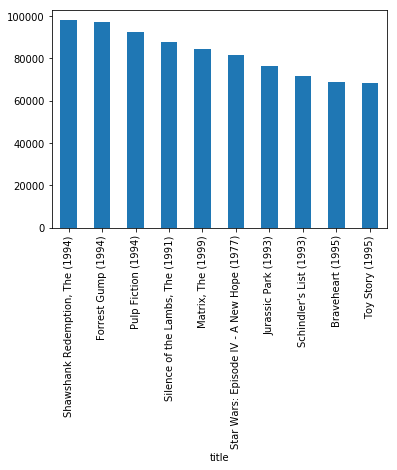

In [12]:
import matplotlib.pyplot as plt
plt.show(df_movies_ratings_group['rating'].count().sort_values(ascending=False)[:10].plot(kind='bar'))

#### Quais os filmes com as maiores médias de avaliações?

In [13]:
df_movies_ratings_group['rating'].mean().sort_values(ascending=False)[:10]

title
Faintheart (2008)                       5.0
White Tiger (1996)                      5.0
Radio Unnameable (2012)                 5.0
Rafter Romance (1933)                   5.0
Who Killed Chea Vichea? (2010)          5.0
Gesuzza, La Sposa Garibaldina (1934)    5.0
Ram Dass: Fierce Grace (2001)           5.0
Ramen Shop (2018)                       5.0
Ramona (1936)                           5.0
Absolutely Fabulous (2001)              5.0
Name: rating, dtype: float64

Precisamos filtrar pelo número de avaliações para evitar que filmes com poucas avaliações entrem na média. Seria interessante definir um número mínimo de avaliações para extrair a média de um filme (ex: 1000 avaliações).

In [0]:
df_movies_mean_count = df_movies_ratings_group['rating'].agg(['mean', 'count'])

In [15]:
df_movies_mean_count.head(10)

,mean,count
title,,
"""Great Performances"" Cats (1998)",2.815556,225
#1 Cheerleader Camp (2010),2.777778,9
#Captured (2017),2.500000,1
#Horror (2015),2.078947,19
#SCREAMERS (2016),2.500000,1
#chicagoGirl: The Social Network Takes on a Dictator (2013),3.000000,5
#realityhigh (2017),3.361111,18
$ (Dollars) (1971),2.781250,32
"$1,000 on the Black (1966)",3.333333,3


In [16]:
df_movies_mean_count[df_movies_mean_count['count'] > 1000].head()

,mean,count
title,,
"'burbs, The (1989)",3.114900,3812
(500) Days of Summer (2009),3.754684,12437
*batteries not included (1987),3.260588,2007
...And Justice for All (1979),3.632479,1287
10 Cloverfield Lane (2016),3.679677,3100


In [18]:
# 10 filmes melhor avaliados
df_movies_mean_count[df_movies_mean_count['count'] > 1000].sort_values(by='mean', ascending=False).head(10)

,mean,count
title,,
Planet Earth (2006),4.458092,1384
"Shawshank Redemption, The (1994)",4.424188,97999
Black Mirror: White Christmas (2014),4.350559,1074
"Godfather, The (1972)",4.332893,60904
"Usual Suspects, The (1995)",4.291959,62180
"Godfather: Part II, The (1974)",4.263035,38875
Schindler's List (1993),4.257502,71516
Seven Samurai (Shichinin no samurai) (1954),4.254116,14578
12 Angry Men (1957),4.237075,17931


In [19]:
# 10 filmes pior avaliados
df_movies_mean_count[df_movies_mean_count['count'] > 1000].sort_values(by='mean').head(10)

,mean,count
title,,
Epic Movie (2007),1.472287,1281
Battlefield Earth (2000),1.610675,4965
Baby Geniuses (1999),1.735276,1613
Dumb and Dumberer: When Harry Met Lloyd (2003),1.762450,2008
Free Willy 3: The Rescue (1997),1.796917,1103
Stop! Or My Mom Will Shoot (1992),1.811079,2067
Friday the 13th Part VIII: Jason Takes Manhattan (1989),1.818613,1370
Police Academy: Mission to Moscow (1994),1.825207,1087
Spice World (1997),1.826339,3193


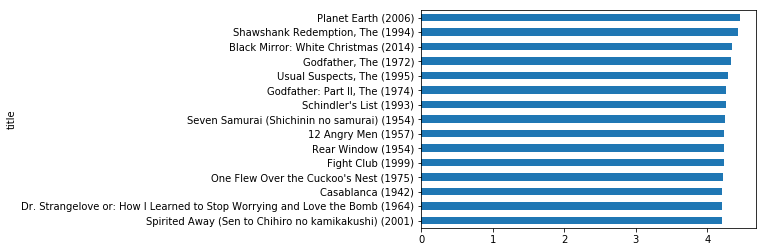

In [20]:
plt.show(df_movies_mean_count[df_movies_mean_count['count'] > 1000].sort_values(by='mean', ascending=False)['mean'].head(15).plot(kind='barh').invert_yaxis())

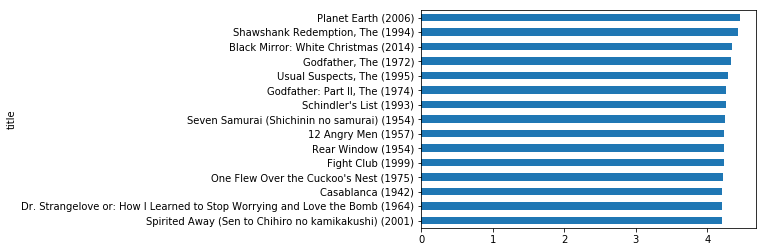

In [26]:
# Salvando o gráfico como imagem png
df_movies_mean_count[df_movies_mean_count['count'] > 1000].sort_values(by='mean', ascending=False)['mean'].head(15).plot(kind='barh').invert_yaxis()
plt.savefig('movies_mean_rating.png')

In [28]:
!ls -la

total 32
drwxr-xr-x 1 root root  4096 Oct 16 20:53 .
drwxr-xr-x 1 root root  4096 Oct 16 20:25 ..
drwxr-xr-x 1 root root  4096 Oct 11 15:15 .config
-rw-r--r-- 1 root root 15386 Oct 16 20:58 movies_mean_rating.png
drwxr-xr-x 1 root root  4096 Aug 27 16:17 sample_data


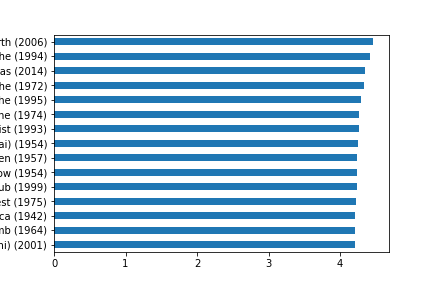

In [31]:
from IPython.display import Image
Image(filename='movies_mean_rating.png') 

In [0]:
# Salvando um Dataframe em arquivo
df_movies_mean_count.to_csv('movies_mean_count.csv')

In [33]:
!ls -la

total 2204
drwxr-xr-x 1 root root    4096 Oct 16 21:01 .
drwxr-xr-x 1 root root    4096 Oct 16 20:25 ..
drwxr-xr-x 1 root root    4096 Oct 11 15:15 .config
-rw-r--r-- 1 root root 2222508 Oct 16 21:01 movies_mean_count.csv
-rw-r--r-- 1 root root   15386 Oct 16 20:58 movies_mean_rating.png
drwxr-xr-x 1 root root    4096 Aug 27 16:17 sample_data


In [36]:
with open('movies_mean_count.csv') as f:
  lines = f.readlines()

for l in lines[:10]:
  print(l)

title,mean,count

"""Great Performances"" Cats (1998)",2.8155555555555556,225

#1 Cheerleader Camp (2010),2.7777777777777777,9

#Captured (2017),2.5,1

#Horror (2015),2.0789473684210527,19

#SCREAMERS (2016),2.5,1

#chicagoGirl: The Social Network Takes on a Dictator (2013),3.0,5

#realityhigh (2017),3.361111111111111,18

$ (Dollars) (1971),2.78125,32

"$1,000 on the Black (1966)",3.3333333333333335,3

